In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ait511/sample_submission.csv
/kaggle/input/ait511/train.csv
/kaggle/input/ait511/test.csv


In [3]:
df = pd.read_csv("/kaggle/input/ait511/train.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15533 entries, 0 to 15532
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              15533 non-null  int64  
 1   Gender                          15533 non-null  object 
 2   Age                             15533 non-null  float64
 3   Height                          15533 non-null  float64
 4   Weight                          15533 non-null  float64
 5   family_history_with_overweight  15533 non-null  object 
 6   FAVC                            15533 non-null  object 
 7   FCVC                            15533 non-null  float64
 8   NCP                             15533 non-null  float64
 9   CAEC                            15533 non-null  object 
 10  SMOKE                           15533 non-null  object 
 11  CH2O                            15533 non-null  float64
 12  SCC                             

In [5]:
df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,15533.000000,15533.000000,15533.000000,15533.000000,15533.000000,15533.000000,15533.000000,15533.000000,15533.000000
mean,7766.000000,23.816308,1.699918,87.785225,2.442917,2.760425,2.027626,0.976968,0.613813
std,4484.135201,5.663167,0.087670,26.369144,0.530895,0.706463,0.607733,0.836841,0.602223
min,0.000000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,3883.000000,20.000000,1.630927,66.000000,2.000000,3.000000,1.796257,0.007050,0.000000
50%,7766.000000,22.771612,1.700000,84.000000,2.342220,3.000000,2.000000,1.000000,0.566353
75%,11649.000000,26.000000,1.762921,111.600553,3.000000,3.000000,2.531456,1.582675,1.000000
max,15532.000000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [6]:
class_dist = df['WeightCategory'].value_counts()
class_dist

WeightCategory
Obesity_Type_III       2983
Obesity_Type_II        2403
Normal_Weight          2345
Obesity_Type_I         2207
Overweight_Level_II    1881
Insufficient_Weight    1870
Overweight_Level_I     1844
Name: count, dtype: int64

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

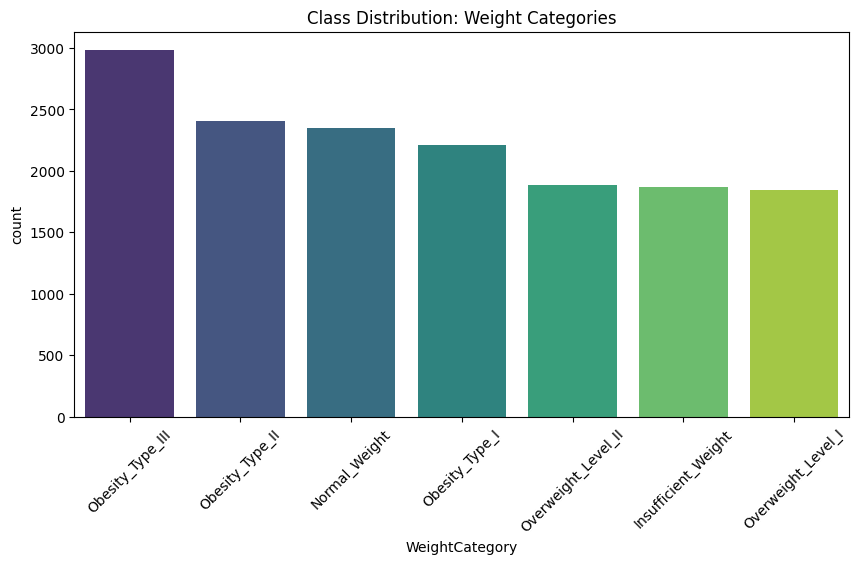

In [11]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='WeightCategory', order=df['WeightCategory'].value_counts().index, palette='viridis')
plt.xticks(rotation=45)
plt.title("Class Distribution: Weight Categories")
plt.show()

In [22]:
weight_order = [
    'Insufficient_Weight',
    'Normal_Weight',
    'Overweight_Level_I',
    'Overweight_Level_II',
    'Obesity_Type_I',
    'Obesity_Type_II',
    'Obesity_Type_III'
]

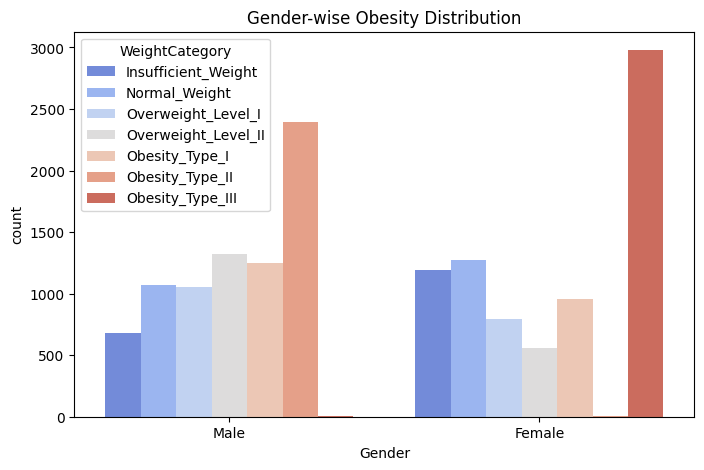

In [24]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Gender', hue='WeightCategory', hue_order = weight_order, palette='coolwarm')
plt.title("Gender-wise Obesity Distribution")
plt.show()


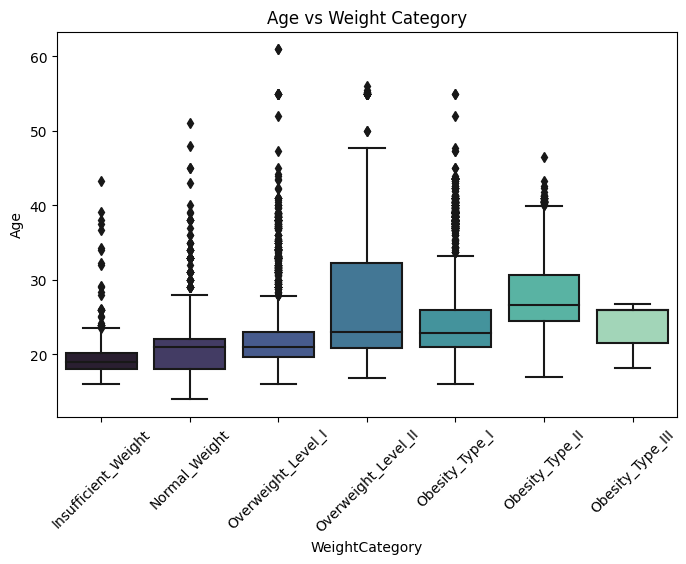

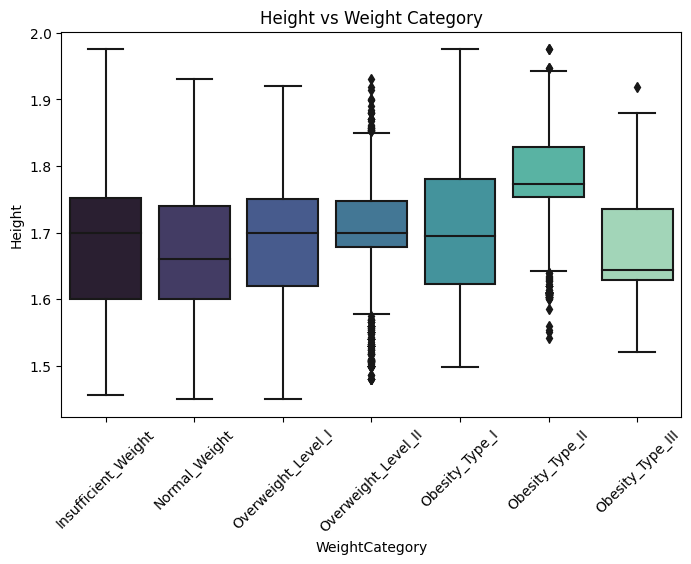

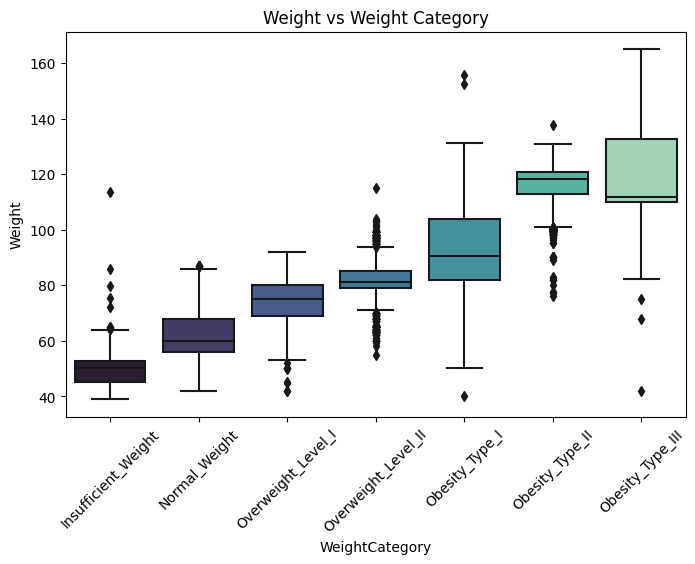

In [25]:
num_features = ['Age', 'Height', 'Weight']

for col in num_features:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='WeightCategory', y=col,order = weight_order, palette='mako')
    plt.xticks(rotation=45)
    plt.title(f"{col} vs Weight Category")
    plt.show()


In [19]:
import warnings
warnings.filterwarnings('ignore')


<Figure size 1400x800 with 0 Axes>

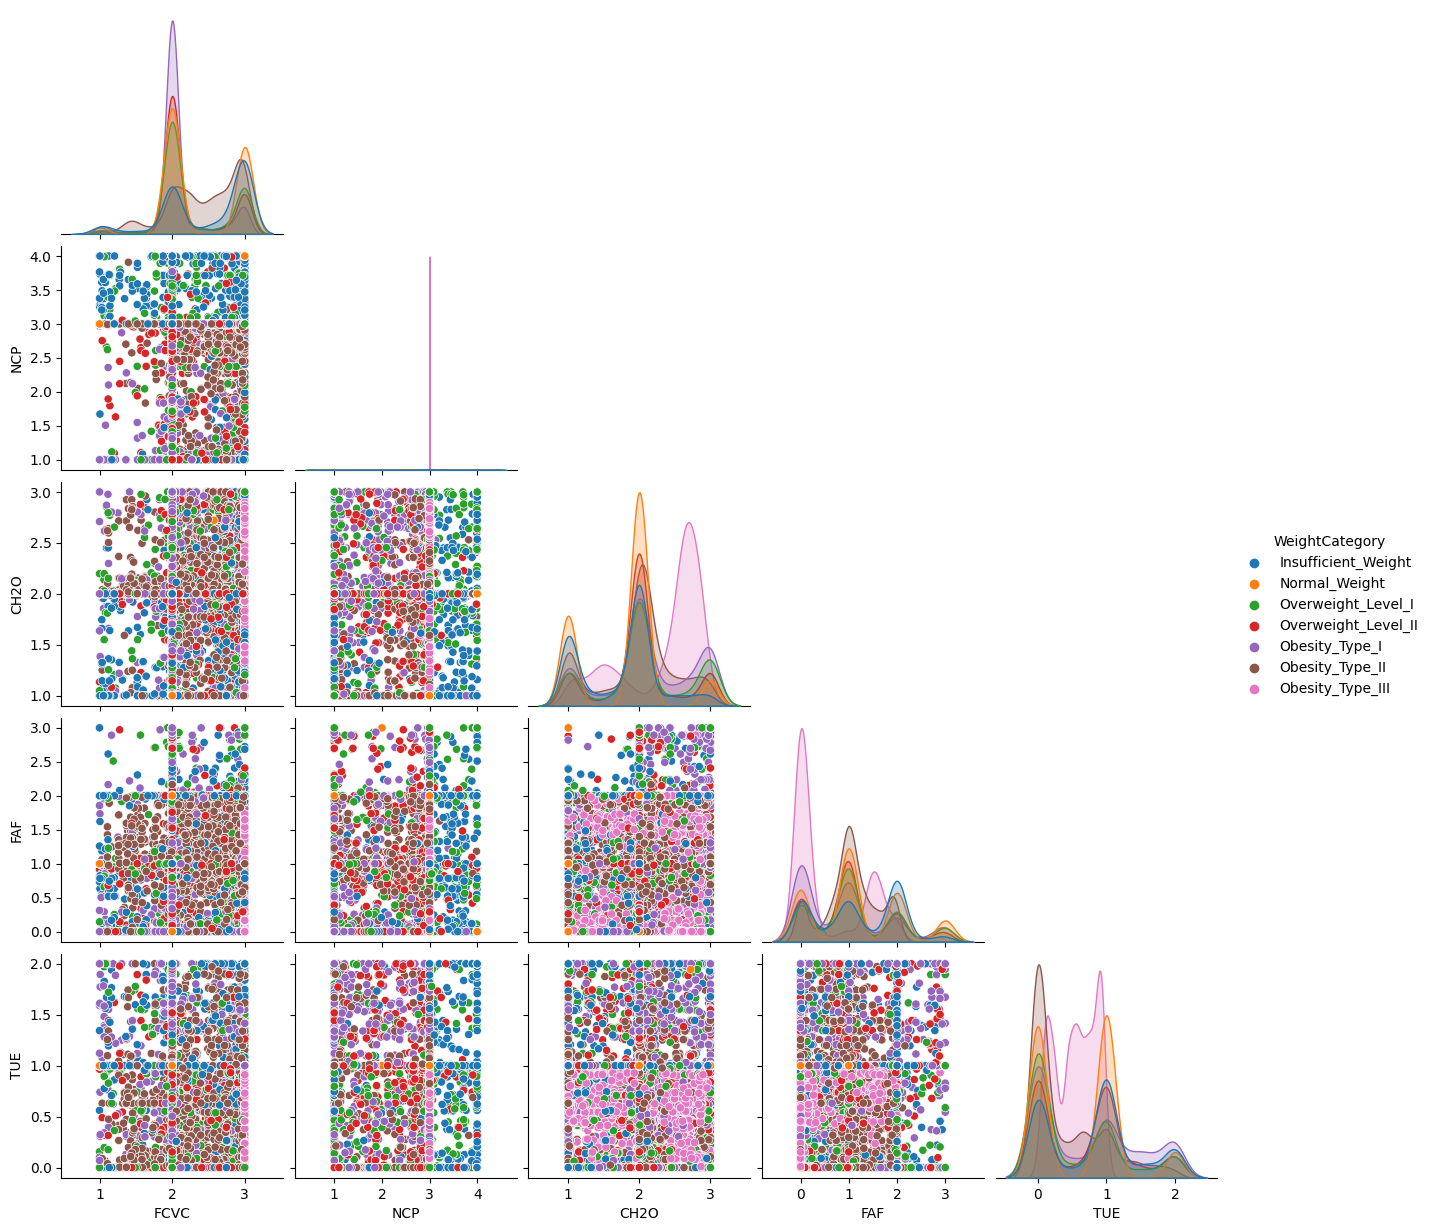

In [30]:
features = ['FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
plt.figure(figsize=(14,8))
sns.pairplot(df, vars=features, hue='WeightCategory',hue_order = weight_order, corner=True)
plt.show()


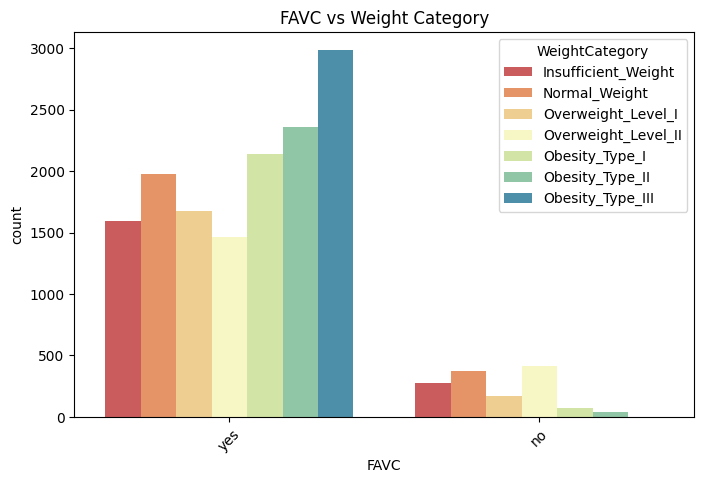

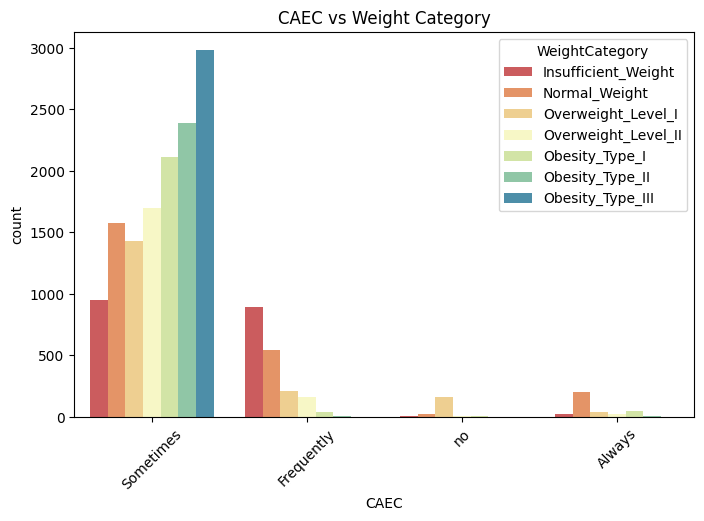

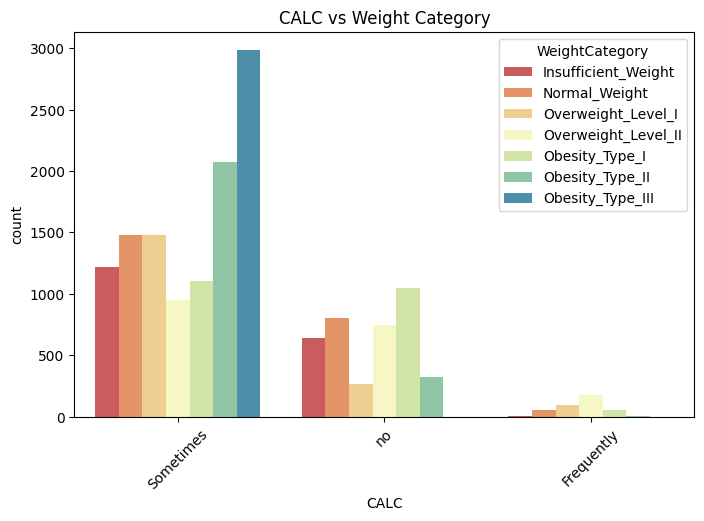

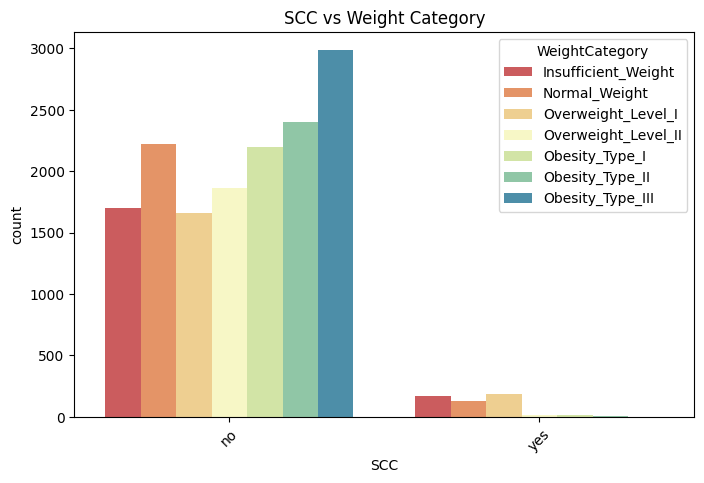

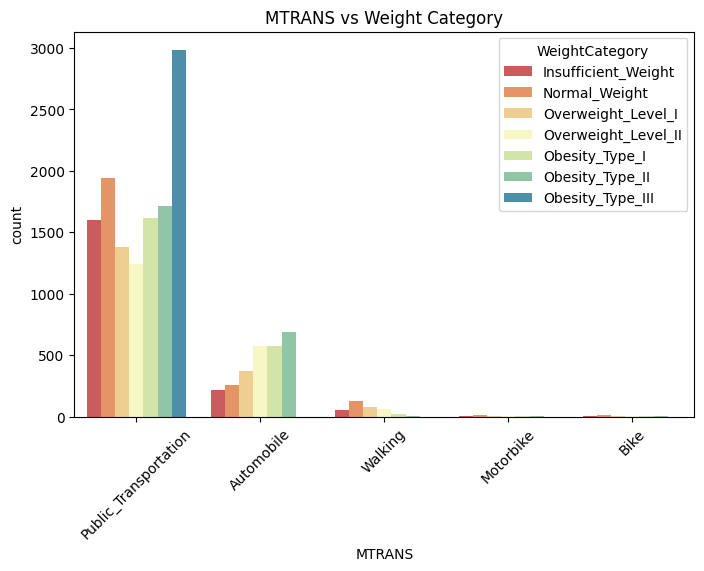

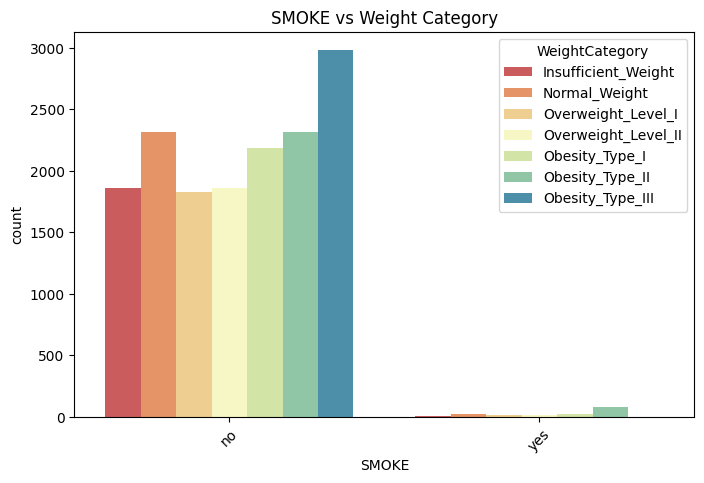

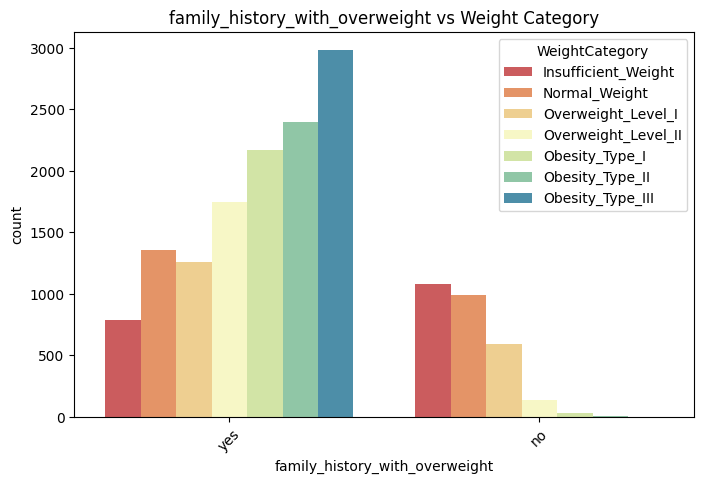

In [27]:
cat_features = ['FAVC','CAEC','CALC','SCC','MTRANS','SMOKE','family_history_with_overweight']

for col in cat_features:
    plt.figure(figsize=(8,5))
    sns.countplot(data=df, x=col, hue='WeightCategory',hue_order = weight_order, palette='Spectral')
    plt.title(f"{col} vs Weight Category") 
    plt.xticks(rotation=45)
    plt.show()


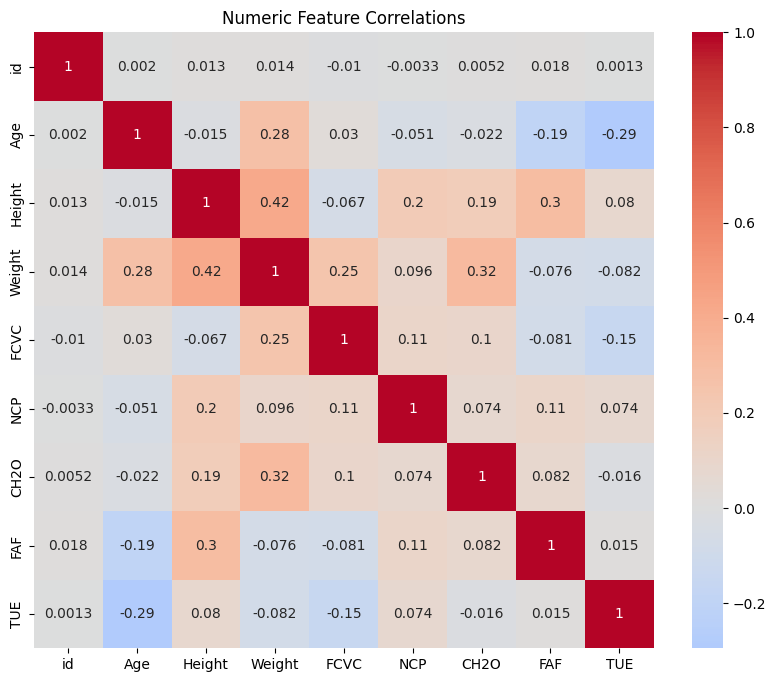

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', center=0)
plt.title("Numeric Feature Correlations")
plt.show()


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


In [7]:
df = pd.read_csv("/kaggle/input/ait511/train.csv")

In [11]:

# Convert boolean columns to integers as they behave like categorical in some contexts
bool_cols = df.select_dtypes(include="bool").columns
df[bool_cols] = df[bool_cols].astype(int)

# Encode categorical columns (object type)
cat_cols = df.select_dtypes(include="object").columns
for c in cat_cols:
    df[c] = df[c].astype("category").cat.codes

display(df.head())


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,2,0,2.763573,0,0.000000,0.976473,1,3,6
1,1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,1,0,2.000000,0,1.000000,1.000000,2,0,1
2,2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,2,0,1.910378,0,0.866045,1.673584,2,3,0
3,3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,2,0,1.674061,0,1.467863,0.780199,1,3,4
4,4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,2,0,1.979848,0,1.967973,0.931721,1,3,6


In [1]:
# ==============================================
# OPTUNA TUNING (No Cross-Validation)
# For Gradient Boosting, Random Forest, and KNN
# ==============================================

import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_wine

# ------------------------------
# Load dataset (replace with your own)
# ------------------------------

feature_names = X.columns
target_names = ['WeightCategory']

# Main train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split training data for validation
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Scale for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sub)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ==========================================================
# 1️⃣ Gradient Boosting
# ==========================================================
def objective_gb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
    }
    model = GradientBoostingClassifier(random_state=42, **params)
    model.fit(X_train_sub, y_train_sub)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

study_gb = optuna.create_study(direction='maximize', study_name="GradientBoosting")
study_gb.optimize(objective_gb, n_trials=5, n_jobs=-1)

gb_best_params = study_gb.best_params
gb_model = GradientBoostingClassifier(random_state=42, **gb_best_params)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print("\n=== Gradient Boosting Classifier ===")
print("Best Params:", gb_best_params)
print("Test Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb, target_names=target_names))


# ==========================================================
# 2️⃣ Random Forest
# ==========================================================
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
    }
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train_sub, y_train_sub)
    preds = model.predict(X_val)
    return accuracy_score(y_val, preds)

study_rf = optuna.create_study(direction='maximize', study_name="RandomForest")
study_rf.optimize(objective_rf, n_trials=5, n_jobs=-1)

rf_best_params = study_rf.best_params
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1, **rf_best_params)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\n=== Random Forest Classifier ===")
print("Best Params:", rf_best_params)
print("Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=target_names))


# ==========================================================
# 3️⃣ K-Nearest Neighbors
# ==========================================================
def objective_knn(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 3, 25),
        'weights': trial.suggest_categorical('weights', ['uniform', 'distance']),
        'metric': trial.suggest_categorical('metric', ['euclidean', 'manhattan']),
        'p': trial.suggest_int('p', 1, 2),
    }
    model = KNeighborsClassifier(**params)
    model.fit(X_train_scaled, y_train_sub)
    preds = model.predict(X_val_scaled)
    return accuracy_score(y_val, preds)

study_knn = optuna.create_study(direction='maximize', study_name="KNN")
study_knn.optimize(objective_knn, n_trials=5, n_jobs=-1)

knn_best_params = study_knn.best_params
knn_model = KNeighborsClassifier(**knn_best_params)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

print("\n=== K-Nearest Neighbors Classifier ===")
print("Best Params:", knn_best_params)
print("Test Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn, target_names=target_names))


NameError: name 'X' is not defined

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# =============================
# 1) Load data
# =============================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train = train[:16250]
target_col = "NObeyesdad"
y = train[target_col]
X = train.drop(columns=[target_col])
test_ids = test["id"]
X_test = test.copy()

# =============================
# 2) Encode features
# =============================
for df in [X, X_test]:
    bool_cols = df.select_dtypes(include="bool").columns
    df[bool_cols] = df[bool_cols].astype(int)

    cat_cols = df.select_dtypes(include="object").columns
    for c in cat_cols:
        df[c] = df[c].astype("category").cat.codes

# =============================
# 3) Encode target
# =============================
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# =============================
# 4) Stratified K-Fold setup
# =============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# =============================
# 5) Define objective for Optuna
# =============================
def objective(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": len(np.unique(y_encoded)),
        "eval_metric": "mlogloss",
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 0.5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 2.0),
        "seed": 42,
    }

    cv_acc = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)

        bst = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=400,
            evals=[(dval, "eval")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        preds = bst.predict(dval)
        preds_label = preds.argmax(axis=1)
        acc = accuracy_score(y_val, preds_label)
        cv_acc.append(acc)

    return np.mean(cv_acc)


# =============================
# 6) Run Optuna tuning
# =============================
print("🔍 Running Optuna tuning (15 trials)...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, show_progress_bar=True)

print("\n✅ Best params found:")
print(study.best_params)
print(f"Best CV Accuracy: {study.best_value * 100:.2f}%")

best_params = study.best_params
best_params.update({
    "objective": "multi:softprob",
    "num_class": len(np.unique(y_encoded)),
    "eval_metric": "mlogloss",
    "seed": 42
})

# =============================
# 7) Train final model with best params
# =============================
test_pred_prob = np.zeros((len(X_test), len(np.unique(y_encoded))))
oof_preds = np.zeros((len(X), len(np.unique(y_encoded))))

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y_encoded)):
    print(f"\n===== Fold {fold + 1} =====")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)

    evals = [(dtrain, "train"), (dval, "eval")]

    bst = xgb.train(
        params=best_params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=100,
        verbose_eval=100
    )

    best_iter = bst.best_iteration or 1000
    oof_pred_prob = bst.predict(dval, iteration_range=(0, best_iter))
    test_pred_prob += bst.predict(dtest, iteration_range=(0, best_iter)) / skf.n_splits
    oof_preds[val_idx] = oof_pred_prob

    # Add classification report for validation data
    oof_pred_labels_fold = oof_pred_prob.argmax(axis=1)
    print(f"\nClassification Report for Fold {fold + 1}:")
    print(classification_report(y_val, oof_pred_labels_fold, target_names=le.classes_))


# =============================
# 8) Evaluate OOF Accuracy
# =============================
oof_pred_labels = oof_preds.argmax(axis=1)
cv_acc = accuracy_score(y_encoded, oof_pred_labels)
print(f"\nFinal OOF CV Accuracy: {cv_acc * 100:.2f}%")

# =============================
# 9) Save submission
# =============================
y_test_pred = test_pred_prob.argmax(axis=1)
y_test_labels = le.inverse_transform(y_test_pred)

submission = pd.DataFrame({
    "id": test_ids,
    "WeightCategory": y_test_labels
})
submission.to_csv("submission.csv", index=False)
print("\n submission.csv saved successfully!")